This notebook is aimed at looking into the alleles a bit more in terms of variations of the different gene categories (BUSCOs, candidate effectors and such).

The input is based on the following ideas:

* alleles are based on proteinortho -synteny flag
* non-allelic inter-haplome paralogs are genes that cluster on the protein level but are not allelic. These are called ->  non_allelic 'orthologs'  in this notebook as edits to the test were only done after the analysis. Orthologs was not a good term in this case.
* singeltons are genes without a clustered protein in the other haplotype phase blocks
* single haplotype genes are genes that have no gene to genome blast hit e_value = 1e-2 and are not in a homozygous region.


This notebook was only designed for the purpose of analyzing the Pst-104E genome. No gurantees it works in any other situtation. It will have spelling errors due to the lack of autocorrection.

For interal reference only:
Final analysis is based on Pst_104E_v12_missing_allele_QC_v03.ipynb and Pst_104E_v12_defining_alleles_v03.ipynb in folder 
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis/no_alleles_proteinortho_graph516_QC_Qcov80_PctID70_evalue01 and alleles_proteinortho_graph516


In [97]:
%matplotlib inline

In [57]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import statsmodels as sms
import statsmodels.sandbox.stats.multicomp
import distance
import seaborn as sns
from pybedtools import BedTool

In [2]:
pwh_set = []
def pwh_filter (q_contig, pwh_set=pwh_set):
    '''Checks if contig belongs to the primary with haplotig set.'''
    if q_contig in pwh_set:
        return True
    else:
        return False

In [3]:
def on_primary_contig (q_contig):
    '''Quick function that checks if query is on primary contig or not'''
    if q_contig.startswith('hcontig'):
        return False
    elif q_contig.startswith('pcontig'):
        return True
    else:
        print('Contig annotation needs to start with hcontig or pcontig')

In [4]:
###make a function out of the 5' and 3' prime distance
def _5_to_3_df(ref_bed_fn, query_bed_fn, io=False ):
    """Takes two bed6 filenames and returns dataframe with 5' and 3' distances."""
    from pybedtools import BedTool
    ref = BedTool(ref_bed_fn)
    query = BedTool(query_bed_fn)

    sub_3 = ref.closest(query ,io=io,  N=True, iu=True, D='a' ).to_dataframe()
    sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, \
                 inplace=True)
    sub_5 = ref.closest(query,\
                                io=io,N=True, id=True, D='a' ).to_dataframe()
    sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

    #merging them
    sub_merged = sub_3.merge(sub_5, on=['query', 'contig'])

    #needs to be fixed to take boundaries into account
    #remove genes on the edges
    sub_merged = sub_merged [((sub_merged['5_target'] != '.') & (sub_merged['3_target'] != '.') )  ]
    sub_merged['5_distance'] = sub_merged['5_distance'].apply(lambda x: np.absolute(x))
    return sub_merged

In [5]:
#define a function that subsets a dataframe to the inner quantil residual columnwise
def quant_cut_df(dataframe):
    nn_df = dataframe.copy()
    iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_low.name ='low'
    iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_high.name = 'high'

    iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

    iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
    return iqr_nn_df 


In [32]:
def len_per_gene(gene_list, gg_fasta):
    '''Returns the len per gene in the list plus the len
    for all genes in the genome from using gg_fasta genome gene fasta.'''
    GC_list_genes = []
    GC_list_genome = []
    for x in SeqIO.parse(gg_fasta, 'fasta'):
        GC_list_genome.append(len(x.seq))
        if x.id.replace('TU', 'model') in gene_list:
            GC_list_genes.append(len(x.seq))
    return GC_list_genes, GC_list_genome

def GC_per_gene(gene_list, gg_fasta):
    '''Returns the GC content per gene in the list plus the GC content
    for all genes in the genome from using gg_fasta genome gene fasta.'''
    GC_list_genes = []
    GC_list_genome = []
    for x in SeqIO.parse(gg_fasta, 'fasta'):
        GC_list_genome.append(SeqUtils.GC(x.seq))
        if x.id.replace('TU', 'model') in gene_list:
            GC_list_genes.append(SeqUtils.GC(x.seq))
    return GC_list_genes, GC_list_genome

def return_gene_fasta_paml(gene_list, gg_fasta):
    '''Returns the fasta of gene in list as SeqIO object '''
    genes_fasta = []
    for x in SeqIO.parse(gg_fasta, 'fasta'):
        if x.id.replace('TU', 'model') in gene_list:
            x.id = x.id.replace('TU', 'model')
            genes_fasta.append(x)
    return genes_fasta

def return_gene_fasta(gene_list, gg_fasta):
    '''Returns the fasta of gene in list as SeqIO object '''
    genes_fasta = []
    for x in SeqIO.parse(gg_fasta, 'fasta'):
        if x.id.replace('TU', 'model') in gene_list:
            genes_fasta.append(x)
    return genes_fasta

def return_contig_fasta(contig_list, gg_fasta):
    '''Returns the fasta of contig in list as SeqIO object '''
    contig_fasta = []
    for x in SeqIO.parse(gg_fasta, 'fasta'):
        if x.id in contig_list:
            contig_fasta.append(x)
    return contig_fasta

In [39]:
#make this a function
gene_list_per_contig_dict = {}
def does_have_neighbour(input_gene_list, gene_list_per_contig_dict=gene_list_per_contig_dict):
    '''Return a list of True/False indicating if the respective element of the entry list has 
    a neighbour present in the same list.
    It also requires a dictionary of the ordered gene list per contig.'''
    #get the index of all shg_genes in the ordered gene list
    ordered_gl_index_dict = {}
    #initiat the empty list for the dict
    for key in gene_list_per_contig_dict.keys():
        ordered_gl_index_dict[key] = []
    #now populate those for the genes we have, adding indexes of each in in the list per contig
    for y in input_gene_list:
        contig = re.findall(r'[ph]contig[^.]*', y)[0]
        #get the index of the gene specific for the contig
        _index = gene_list_per_contig_dict[contig].index(y.replace('model', 'TU'))
        #append it to the specfic contig list
        ordered_gl_index_dict[contig].append(_index)
    have_neighbours = []
    #now loop over the list dictonary and see if each list contains an index+-1
    for key in ordered_gl_index_dict.keys():
        subset_gene_index_list = ordered_gl_index_dict[key]
        for y in subset_gene_index_list:
            if y+1 in subset_gene_index_list or y-1 in subset_gene_index_list:
                have_neighbours.append(True)
            else:
                have_neighbours.append(False)
    return have_neighbours

In [58]:
def elements_with_overlap(gene_list, all_gene_bed_fn, feature_bed_fn):
    """The takes a list of genes/proteins and checks which of those overlap with
    a feature in the feature bed.
    Returns the number of elements with overlap and
    number of tested overlaps."""
    from pybedtools import BedTool
    tmp_gene_df = pd.read_csv(all_gene_bed_fn, header=None, sep='\t')
    #now subset the tmp_gene_df and save to file
    tmp_fn = all_gene_bed_fn.replace('bed','bed_tmp')
    #fix gene list
    new_gene_list = []
    for x in gene_list:
        if 'model' in x:
            new_gene_list.append(x.replace('model', 'TU'))
        elif 'TU' in x:
            new_gene_list.append(x)
        
    tmp_gene_df[tmp_gene_df[3].isin(new_gene_list)]\
                .to_csv(tmp_fn, header =None, sep='\t', index=None)
    tmp_gene_bed = BedTool(tmp_fn)
    feature_bed = BedTool(feature_bed_fn)
    tmp_bed = tmp_gene_bed.intersect(feature_bed,c=True)
    total_querries = len(tmp_bed)
    querries_w_overlap = tmp_bed.to_dataframe().iloc[:, -1].sum()
    #n = 0
    return querries_w_overlap, total_querries

In [6]:
#Define the PATH
BASE_AA_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12'
BASE_A_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
BLAST_RESULT_PATH = os.path.join(BASE_AA_PATH,'allele_analysis' )
ALLELE_PATH =os.path.join(BASE_AA_PATH ,'allele_analysis/alleles_proteinortho_graph516')
ALLELE_QC_PATH = os.path.join(BASE_AA_PATH, 'allele_analysis', \
                              'no_alleles_proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
LIST_PATH = os.path.join(BASE_AA_PATH, 'enrichment_analysis', 'lists')
POST_ALLELE_PATH = os.path.join(BASE_AA_PATH, 'post_allele_analysis')
OUT_PATH = os.path.join(POST_ALLELE_PATH, 'proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
OUT_FOLDER_FIG = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/figures'
if not os.path.exists(POST_ALLELE_PATH):
    os.mkdir(POST_ALLELE_PATH)
if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)
ph_gene_fasta = os.path.join(BASE_A_PATH , 'Pst_104E_v12_ph_ctg.anno.gene.fa')
ph_cds_fasta = os.path.join(BASE_A_PATH, 'Pst_104E_v12_ph_ctg.anno.CDS.fa')
ph_protein_fasta = os.path.join(BASE_A_PATH, 'Pst_104E_v12_ph_ctg.anno.protein.fa')

In [7]:
#get all the alleles in as they are not filtered by QCov and PctID but simply taken straight from the 
# proteinortho
allele_header = ['p_gene', 'h_gene']
a_overlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_overlap_df['Linkage'] = 'h_contig_overlap'
a_no_roverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_roverlap_df['Linkage'] = 'no_r_overlap'
a_no_soverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_specific_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_soverlap_df['Linkage'] = 'no_s_overlap'
allele_df = pd.concat([a_overlap_df, a_no_roverlap_df, a_no_soverlap_df], axis=0)

In [8]:
feature_fn_dict = {}
feature_fn_dict['genes'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_all.gene.bed' )
feature_fn_dict['effector'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_effector.gene.bed' )
feature_fn_dict['busco'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_busco.gene.bed' )
feature_fn_dict['haustoria'] = os.path.join(LIST_PATH, 'Pst_104E_v12_cluster_8.gene.bed' )
feature_fn_dict['no_be'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_non_busco_non_effector.gene.bed')
feature_fn_dict['no_effector'] =os.path.join(LIST_PATH, 'Pst_104E_v12_p_noeffector.gene.bed')
feature_fn_dict['no_busco'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_non_busco.gene.bed')
feature_fn_dict['TE_g400'] = os.path.join(LIST_PATH,\
                                'Pst_104E_v12_p_ctg.REPET.sorted.g400_superfamily.bed' )
feature_fn_dict['TE_g1000'] = os.path.join(LIST_PATH,\
                                'Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.bed' )
feature_bed_dict = {}
for key, value in feature_fn_dict.items():
    feature_bed_dict[key] = BedTool(value)

In [9]:
#copy over allele files to OUTPATH
os.chdir(ALLELE_PATH)
!cp Pst_104E_v12_p_ctg.h_contig_overlap.alleles {OUT_PATH}/.
!cp Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles {OUT_PATH}/.
!cp Pst_104E_v12_p_ctg.no_specific_h_contig_overlap.alleles {OUT_PATH}/. 
!cat Pst_104E_v12_p_ctg.h_contig_overlap.alleles Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles Pst_104E_v12_p_ctg.no_specific_h_contig_overlap.alleles > {OUT_PATH}/Pst_104E_v12_p_ctg.all.alleles

In [10]:
#get the blast dataframe and the QC dataframe
allele_blast_df = pd.read_csv(os.path.join(BLAST_RESULT_PATH, 'Pst_104E_v12_p_ctg.Pst_104E_v12_h_ctg.0.001.blastp.outfmt6.allele_analysis'), sep='\t')
allele_QC_df = pd.read_csv(os.path.join(ALLELE_QC_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_QC.Qcov80.PctID70.df'), sep='\t')

/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
#now filter out all the genes that already have alleles based on the protein ortho results
#this does not care about the 'abirary' cut offs for coverage and PctID
allele_QC_df = pd.read_csv(os.path.join(ALLELE_QC_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_QC.Qcov80.PctID70.df'), sep='\t')
allele_QC_df = allele_QC_df[~((allele_QC_df.Query.isin(allele_df.p_gene))|(allele_QC_df.Query.isin(allele_df.h_gene)))].copy()


/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
#quick check if all the numbers of genes add up
len(allele_df.p_gene.unique())+ len(allele_df.h_gene.unique())+len(allele_QC_df.Query.unique()) == 30249

True

In [13]:
#now write out all no_allele_orthologs
no_allele_orthologs_fn = os.path.join(OUT_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_orthologs')
no_allele_orthologs = allele_QC_df[allele_QC_df.singeltons == False]["Query"].unique()
tmp_fh = open(no_allele_orthologs_fn, 'w')
for _id in allele_QC_df[allele_QC_df.singeltons == False]["Query"].unique():
    print(_id, file=tmp_fh)
tmp_fh.close()

In [14]:
#write out singeltons
singeltons_fh = os.path.join(OUT_PATH, 'Pst_104E_v12_ph_ctg.singletons')
singeltons = allele_QC_df[(allele_QC_df.singeltons == True) & (allele_QC_df.ph_p_homo_region != True)]["Query"].unique()
tmp_fh = open(singeltons_fh , 'w')
for _id in singeltons:
    print(_id, file=tmp_fh)
tmp_fh.close()

In [15]:
#write out loose singeltons. This includes all the genes that are singletons also those that 
#are unphased
loose_singeltons_fh = os.path.join(OUT_PATH, 'Pst_104E_v12_ph_ctg.loose_singletons')
loose_singeltons = allele_QC_df[(allele_QC_df.singeltons == True) ]["Query"].unique()
tmp_fh = open(loose_singeltons_fh , 'w')
for _id in loose_singeltons:
    print(_id, file=tmp_fh)
tmp_fh.close()

In [16]:
#write out single nuclear genes defined as having no genome blast, being not in homozygous regions,
#and being singeltons
shg_df = allele_QC_df[(allele_QC_df.singeltons == True) & (allele_QC_df.gene_on_genome_blast_hit != True)\
            &(allele_QC_df.ph_p_homo_region != True)].copy()
shg_fh = os.path.join(OUT_PATH, 'Pst_104E_v12_ph_ctg.single_haplotype_genes')
shg = shg_df.Query.unique()
tmp_fh = open(shg_fh, 'w')
for _id in shg:
    print(_id, file=tmp_fh)
tmp_fh.close()

In [17]:
#now read in some types of genes
gene_group_list = ['BUSCOS', 'EFFECTORS', 'HAUSTORIA', 'EFFECTORP']
p_gene_dict = {}
h_gene_dict = {}
p_gene_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_busco.list')\
                                    , header=None)[0].tolist()
p_gene_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effector.list')\
                                    , header=None)[0].tolist()
p_gene_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_cluster_8.list')\
                                    , header=None)[0].tolist()
p_gene_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effectorp.list')\
                                    , header=None)[0].tolist()
p_gene_dict['SIGNALP3'] = pd.read_csv(os.path.join(LIST_PATH, '..', 'pa_26062017',\
                            'Pst_104E_v12_p_ctg.SignalP3.tablist'), header=None, sep='\t')[0].tolist()

h_gene_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_busco.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effector.list')\
                                    , header=None)[0].tolist()
h_gene_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_cluster_15.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effectorp.list')\
                                    , header=None)[0].tolist()
h_gene_dict['SIGNALP3'] = pd.read_csv(os.path.join(LIST_PATH, '..', 'pa_26062017',\
                            'Pst_104E_v12_h_ctg.SignalP3.tablist'), header=None, sep='\t')[0].tolist()

#now get pwh and pwoh
pwh_list = pd.read_csv(os.path.join(BASE_A_PATH, 'Pst_104E_v12_pwh.txt')\
                                , header=None)[0].tolist()
pwoh_list = pd.read_csv(os.path.join(BASE_A_PATH, 'Pst_104E_v12_pwoh.txt')\
                                , header=None)[0].tolist()

In [18]:
#now read in some types of genes
gene_group_list = ['BUSCOS', 'EFFECTORS', 'HAUSTORIA', 'EFFECTORP']
p_bed_dict = {}
h_bed_dict = {}
p_bed_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_busco.list')\
                                    , header=None)[0].tolist()
p_bed_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effector.list')\
                                    , header=None)[0].tolist()
p_bed_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_cluster_8.list')\
                                    , header=None)[0].tolist()
p_bed_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_effectorp.list')\
                                    , header=None)[0].tolist()
p_gene_dict['SIGNALP3'] = pd.read_csv(os.path.join(LIST_PATH, '..', 'pa_26062017',\
                            'Pst_104E_v12_p_ctg.SignalP3.tablist'), header=None, sep='\t')[0].tolist()

h_gene_dict['BUSCOS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_busco.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORS'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effector.list')\
                                    , header=None)[0].tolist()
h_gene_dict['HAUSTORIA'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_cluster_15.list')\
                                    , header=None)[0].tolist()
h_gene_dict['EFFECTORP'] = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_effectorp.list')\
                                    , header=None)[0].tolist()
h_gene_dict['SIGNALP3'] = pd.read_csv(os.path.join(LIST_PATH, '..', 'pa_26062017',\
                            'Pst_104E_v12_h_ctg.SignalP3.tablist'), header=None, sep='\t')[0].tolist()


In [19]:
#cause we are a bit lazy an like notebooks here we go looking for stuff
os.chdir(BASE_A_PATH)
print("Effectors on pwh contigs")
!cat Pst_104E_v12_pwh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_effector.gene.gff3 | wc -l 

Effectors on pwh contigs
1523


In [20]:
print("Effectors on pwoh contigs")
!cat Pst_104E_v12_pwoh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_effector.gene.gff3 | wc -l 

Effectors on pwoh contigs
49


In [21]:
print("BUSCOS on pwoh contigs")
!cat Pst_104E_v12_pwoh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_busco.gene.gff3 | wc -l 

BUSCOS on pwoh contigs
49


In [22]:
print("BUSCOS on pwh contigs")
!cat Pst_104E_v12_pwh.txt | xargs -I X grep -w 'X' {LIST_PATH}/Pst_104E_v12_p_busco.gene.gff3 | wc -l 

BUSCOS on pwh contigs
1395


In [23]:
print("BUSCOS on hcontigs")
!wc -l {LIST_PATH}/Pst_104E_v12_h_busco.gene.gff3

BUSCOS on hcontigs
1293 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_h_busco.gene.gff3


In [24]:
#this name is a bit unfortunate and historic. It is simple function that takes a list of
#gene ids and check which of those are BUSCOs, effectors and on primary contigs with
#or without haplotigs
def orphan_analysis(_orphan_list):
    """
    This is a function that prints out the numbers of total genes and how many of those are
    buscos or effectors. The same for haplotigs, primary contigs with haplotigs, and 
    primary contigs without haplotigs.
    """
    orphan_effectors = 0
    orphan_effectors_h = 0
    orphan_effectors_pwh = 0
    orphan_effectors_pwoh =0
    orphan_busco = 0
    orphan_busco_h = 0
    orphan_busco_pwh = 0
    orphan_busco_pwoh = 0
    for x in _orphan_list:
        if x in p_gene_dict['BUSCOS']:
            contig = re.search(r'[hp][^.]*',x).group()
            if pwh_filter(contig, pwh_list) == True:
                orphan_busco_pwh += 1
            else:
                orphan_busco_pwoh += 1
        if x in h_gene_dict['BUSCOS']:
            orphan_busco_h += 1
        #now same for effectors    
        if x in p_gene_dict['EFFECTORS']:
            contig = re.search(r'[hp][^.]*',x).group()
            if pwh_filter(contig, pwh_list) == True:
                orphan_effectors_pwh += 1
            else:
                orphan_effectors_pwoh += 1
            
        if x in h_gene_dict['EFFECTORS']:
            orphan_effectors_h += 1      
    orphan_effectors = orphan_effectors_h + orphan_effectors_pwh + orphan_effectors_pwoh
    orphan_busco = orphan_busco_h +  orphan_busco_pwh +  orphan_busco_pwoh
    print('Out of %i genes we have %i buscos and %i effectors.'\
          %(len(_orphan_list), orphan_busco, orphan_effectors))
    print('On haplotigs. Out of %i genes we have %i buscos and %i effectors.'\
         %(len([x for x in _orphan_list if 'hcontig' in x]), orphan_busco_h, orphan_effectors_h))
    print('On pwh. Out of %i genes we have %i buscos and %i effectors.'\
         %([pwh_filter(re.search(r'[hp][^.]*',x).group(), pwh_list) for x in _orphan_list].count(True), orphan_busco_pwh, orphan_effectors_pwh))
    print('On pwoh. Out of %i genes we have %i buscos and %i effectors.'\
         %([pwh_filter(re.search(r'[hp][^.]*',x).group(), pwh_list) for x in _orphan_list if 'pcontig' in x].count(False), orphan_busco_pwoh, orphan_effectors_pwoh))

In [25]:
print("Number of genes without clear allele:")
len(singeltons)

Number of genes without clear allele:


7029

In [26]:
print("For single haplotype genes:")
orphan_analysis(shg)

For single haplotype genes:
Out of 1506 genes we have 125 buscos and 120 effectors.
On haplotigs. Out of 160 genes we have 6 buscos and 5 effectors.
On pwh. Out of 1149 genes we have 93 buscos and 98 effectors.
On pwoh. Out of 197 genes we have 26 buscos and 17 effectors.


In [27]:
print("For singletons:")
orphan_analysis(singeltons)

For singletons:
Out of 7029 genes we have 234 buscos and 453 effectors.
On haplotigs. Out of 2931 genes we have 57 buscos and 153 effectors.
On pwh. Out of 3700 genes we have 147 buscos and 270 effectors.
On pwoh. Out of 398 genes we have 30 buscos and 30 effectors.


In [28]:
print("For loose singletons:")
orphan_analysis(loose_singeltons)

For loose singletons:
Out of 7692 genes we have 297 buscos and 502 effectors.
On haplotigs. Out of 2931 genes we have 57 buscos and 153 effectors.
On pwh. Out of 4289 genes we have 205 buscos and 318 effectors.
On pwoh. Out of 472 genes we have 35 buscos and 31 effectors.


In [ ]:
#set the coverage limits
QCov_limit = 80
PctID_limit = 70
#now get all the ids for which we have hits above the cut off and are singletons
tmp_df = allele_QC_df[allele_QC_df.Target != 'False'] #filter out no hits
tmp_df[['QCov', 'PctID']] = tmp_df[['QCov', 'PctID']].apply(pd.to_numeric) #make numeric
#get ids of stuff above the cut off
tmp_df_ids = tmp_df[(tmp_df.QCov >= QCov_limit) & (tmp_df.PctID >= PctID_limit)]['Query'].unique()
#filter those out and everything that is not a singleton
tmp_df = allele_QC_df[~((allele_QC_df.Query.isin(tmp_df_ids)) | (allele_QC_df.singeltons == False))].copy()

Look at some features of the single haplotype genes (shg) such as:
* gene/protein length
* gc content
* numbers of exons
* distance to TEs?

In [29]:
#now look at single haplotype genes
#This looks for the protein length
shg_df.drop_duplicates('Query')['QLgth'].mean()

349.0830013280212

In [30]:
allele_blast_df.drop_duplicates('Query')['QLgth'].mean()

394.5913485685585

In [31]:
stats.ranksums(shg_df.drop_duplicates('Query')['QLgth'],allele_blast_df.drop_duplicates('Query')['QLgth'] )

RanksumsResult(statistic=-4.8498250071590965, pvalue=1.2357044232530989e-06)

In [33]:
shg_GC, genome_GC = GC_per_gene(shg, ph_gene_fasta)

In [34]:
#gc content per gene
print(np.mean(shg_GC), np.mean(genome_GC))

45.936932047 45.7863006323


In [35]:
#testing difference
stats.ranksums(shg_GC, genome_GC)

RanksumsResult(statistic=1.7879649018298396, pvalue=0.073781670619541995)

In [36]:
#gene length
shg_len, genome_len = len_per_gene(shg, ph_gene_fasta)

In [37]:
#testing difference
print(np.mean(shg_len), np.mean(genome_len))
stats.ranksums(shg_len, genome_len)

1334.79282869 1538.62967371


RanksumsResult(statistic=-4.8395122876180281, pvalue=1.3015814430474663e-06)

In [ ]:
#get gene fastas and save those
shg_fasta = return_gene_fasta(shg, ph_gene_fasta)
shg_fn = os.path.join(OUT_PATH, "Pst_104E_v12_ph_ctg.single_haplotype_genes.fasta")
with open(shg_fn, 'w') as fh:
    SeqIO.write(shg_fasta, fh, 'fasta')

In [ ]:
#get gene fastas and save those
shg_fasta = return_gene_fasta(shg, ph_cds_fasta)
shg_fn = os.path.join(OUT_PATH, "Pst_104E_v12_ph_ctg.single_haplotype_genes.cds.fasta")
with open(shg_fn, 'w') as fh:
    SeqIO.write(shg_fasta, fh, 'fasta')

In [41]:
#read in gene beds
p_gene_bed = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_p_all.gene.bed'), header=None, sep='\t')
h_gene_bed = pd.read_csv(os.path.join(LIST_PATH, 'Pst_104E_v12_h_all.gene.bed'), header=None, sep='\t')


The next section is about if single haplotype genes cluster together in the sense to check if one of their heighbours is also a single haplotype gene

In [42]:
#look into if shg are more likely to be neighbours and a random subsample
p_genes_ordered = p_gene_bed.sort_values([0, 1])[3].tolist()
h_genes_ordered = h_gene_bed.sort_values([0, 1])[3].tolist()
#make a dict that contains ordered gene lists per contig
gene_list_per_contig_dict = {}
for gene in p_genes_ordered:
    contig = re.findall(r'[ph]contig[^.]*', gene)[0]
    if not contig in gene_list_per_contig_dict.keys():
        gene_list_per_contig_dict[contig] = [x for x in p_genes_ordered if contig in x]
for gene in h_genes_ordered:
    contig = re.findall(r'[ph]contig[^.]*', gene)[0]
    if not contig in gene_list_per_contig_dict.keys():
        gene_list_per_contig_dict[contig] = [x for x in h_genes_ordered if contig in x]

In [43]:
#quick check if we got all genes
count = 0
for x in gene_list_per_contig_dict.values():
    count += len(x)
count == (len(p_genes_ordered) + len(h_genes_ordered))

True

In [44]:
#get the index of all shg_genes in the ordered gene list
ordered_gl_index_dict = {}
#initiat the empty list for the dict
for key in gene_list_per_contig_dict.keys():
    ordered_gl_index_dict[key] = []
#now populate those for the genes we have
for y in shg:
    contig = re.findall(r'[ph]contig[^.]*', y)[0]
    #get the index of the gene specific for the contig
    _index = gene_list_per_contig_dict[contig].index(y.replace('model', 'TU'))
    #append it to the specfic contig list
    ordered_gl_index_dict[contig].append(_index)
        

In [49]:
have_neighbours = []
for key in ordered_gl_index_dict.keys():
    subset_gene_index_list = ordered_gl_index_dict[key]
    for y in subset_gene_index_list:
        if y+1 in subset_gene_index_list or y-1 in subset_gene_index_list:
            have_neighbours.append(True)
        else:
            have_neighbours.append(False)
    

In [52]:
#number of shg genes with neighbours
does_have_neighbour(shg,gene_list_per_contig_dict).count(True)

1164

In [55]:
#random subsampling of genes based on the obsereved numbers of 
#total genes and shg genes per contig
random_gene_list = [p_genes_ordered[x] for x in np.random.choice(15928, 1346,replace=False)]
for _index in np.random.choice(14321,160,replace=False):
    random_gene_list.append(h_genes_ordered[_index])
rand_neighbours = does_have_neighbour(random_gene_list,gene_list_per_contig_dict).count(True)
print(rand_neighbours)
#the final p-value and rand_neighbour neighbour shown in the paper might be different from here
#depending on the random subsample set
stats.fisher_exact([[rand_neighbours, 1506-rand_neighbours],[1164,1506-1164]])

238


(0.05514813489869589, 1.7495940781256474e-269)

In [59]:
##look how much overlap we got
mapped_on_each_other_p_fn = os.path.join(ALLELE_PATH, '..','Pst_104E_v12_p_ctg.p_by_h_cov.gff')
mapped_on_each_other_h_fn = os.path.join(ALLELE_PATH, '..','Pst_104E_v12_ph_ctg.p_on_h_cov.gff')
p_gene_bed_fn = os.path.join(LIST_PATH, 'Pst_104E_v12_p_all.gene.bed')
h_gene_bed_fn = os.path.join(LIST_PATH, 'Pst_104E_v12_h_all.gene.bed')

In [60]:
p_w_overlap, ps = elements_with_overlap(shg, p_gene_bed_fn, mapped_on_each_other_p_fn)
h_w_overlap, hs = elements_with_overlap(shg, h_gene_bed_fn, mapped_on_each_other_h_fn)

In [61]:
print('Out of %i shg %i are have a corresponding associated contig overlap' \
      % (ps+hs, p_w_overlap+ h_w_overlap))

Out of 1506 shg 14 are have a corresponding associated contig overlap


In [62]:
random_gene_list = [p_genes_ordered[x] for x in np.random.choice(15928, 1346, replace=False)]
for _index in np.random.choice(14321,160, replace=False):
    random_gene_list.append(h_genes_ordered[_index])
p_w_overlap, ps = elements_with_overlap(random_gene_list, p_gene_bed_fn, mapped_on_each_other_p_fn)
h_w_overlap, hs = elements_with_overlap(random_gene_list, h_gene_bed_fn, mapped_on_each_other_h_fn)
print('Out of %i random gene list %i are have a corresponding associated contig overlap' \
      % (ps+hs, p_w_overlap+ h_w_overlap))

Out of 1506 random gene list 1250 are have a corresponding associated contig overlap


In [63]:
#I added these values manually. I know they should have really been capture inside a variable.
#the actual numbers might vary depending on the sampling
stats.fisher_exact([[1250, 1506-1250],[14,1506-14]])

(520.36830357142856, 0.0)

The next section is about the single haplotype gene hits in different databases.
Blast was run on the command line.

In [64]:
#have a look after if the shg genes without a blast it in NCBI nt or ensembl cDNA
BLASTR_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/post_allele_analysis/proteinortho_graph516_QC_Qcov80_PctID70_evalue01/blast/'
ensembl_blast = os.path.join(BLASTR_FOLDER, 'Pst_104E_v12_ph_ctg.single_haplotype_genes.cds.0817_e36_cdna.fa.outfmt6')
ncbi_blast = os.path.join(BLASTR_FOLDER,'Pst_104E_ph_ctg.single_haplotype_genes.fasta.NCBI10032017.01.blastn')

In [65]:
ensemblhits = pd.read_csv(ensembl_blast, header=None, sep='\t')[0].unique()
ncbihits = pd.read_csv(ncbi_blast, header=None, sep='\t')[0].unique()
shg_db_hits = [x for x in ensemblhits]
print(len(shg_db_hits ))
for _id in ncbihits:
    if _id.replace('TU', 'model') not in ensemblhits:
        shg_db_hits.append(_id.replace('TU', 'model'))
print(len(shg_db_hits))

1420
1424


In [69]:
#now get single haplotype genes that have no database hits
shg_db_nohits = [x for x in shg if x not in shg_db_hits]
print(len(shg_db_nohits))

82


In [70]:
shg_db_nohits_len = [len(x.seq) for x in return_gene_fasta(shg_db_nohits, ph_gene_fasta)]

In [71]:
print(np.mean(shg_db_nohits_len), np.mean(genome_len))
len([x for x in p_gene_dict['EFFECTORS'] if x in shg_db_nohits])

538.792682927 1538.62967371


9

In [72]:
stats.ttest_ind(shg_db_nohits_len, genome_len)

Ttest_indResult(statistic=-5.1679241077747315, pvalue=2.3820671547152583e-07)

In [73]:
print(np.median(shg_db_nohits_len), np.median(genome_len))

472.0 1196.0


In [74]:
#how many are effectors
print(len([x for x in p_gene_dict['EFFECTORS'] if x in shg_db_nohits]) +\
     len([x for x in h_gene_dict['EFFECTORS'] if x in shg_db_nohits]))


10


In [75]:
#sectreted
print(len([x for x in p_gene_dict['SIGNALP3'] if x in shg_db_nohits]) +\
     len([x for x in h_gene_dict['SIGNALP3'] if x in shg_db_nohits]))

10


In [76]:
#haustoria
print(len([x for x in p_gene_dict['HAUSTORIA'] if x in shg_db_nohits]) +\
     len([x for x in h_gene_dict['HAUSTORIA'] if x in shg_db_nohits]))

0


In [77]:
#quickly check for expression
expression = []
for x  in shg_db_nohits:
    p_counttable = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/expression_analysis/TSRM/Pst_104E_v12_p_ctg/stringtie/Pst_104E_v12_p_ctg.in_house_IDParent.STAR.featureCounts.txt'
    h_counttable = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/expression_analysis/TSRM/Pst_104E_v12_h_ctg/stringtie/Pst_104E_v12_h_ctg.in_house.STAR.featureCounts.txt'
    gene_name = x #.replace("model", "TU")
    if 'pcontig' in x:
        hit = !grep -w '{gene_name}' {p_counttable}
        expression.append(hit)
    if 'hcontig' in x:
        hit = !grep -w '{gene_name}' {h_counttable}
        expression.append(hit)

In [78]:
#make an expression dict were the read counts are a list with each position representig count
#mapped reads under one condition
shg_db_nohits_exp_dict = {}
for x in expression:
    gene = x[0].split('\t')[0]
    shg_db_nohits_exp_dict[gene] = x[0].split('\t')[-18:]

In [79]:
#check if the expression (count of aligned fragments in sum) is > 100;
#the cut off is really a bit abitrary
len([x for x in shg_db_nohits_exp_dict.keys() \
     if np.sum([int(y) for y in shg_db_nohits_exp_dict[x]]) > 100])

27

In [80]:
#check if those are effectors
len([x for x in shg_db_nohits_exp_dict.keys() \
     if (np.sum([int(y) for y in shg_db_nohits_exp_dict[x]]) > 100)\
     and (x in p_gene_dict['EFFECTORS'] or x in h_gene_dict['EFFECTORS'])])

7

The next part is about the allele variation analysis. Using both levenshtein distances and yn00 dN/dS as proxies of variation.
The codmel part is only included for historic reseason and should not be considered part of the analysis

In [81]:
PAML_PATH = os.path.join(OUT_PATH, 'paml')
if not os.path.exists(PAML_PATH):
    os.mkdir(PAML_PATH)

In [ ]:
count = 0
with open(os.path.join(PAML_PATH, 'paml_script.sh'), 'a') as aln_fh:
        print('#!/bin/bash', file=aln_fh)
for index, row in allele_df.iterrows():
    #make new folder
    _tmp_allele_path = os.path.join(PAML_PATH, '%s_%s' % (row[0],row[1]))
    if not os.path.exists(_tmp_allele_path):
        os.mkdir(os.path.join(PAML_PATH, '%s_%s' % (row[0],row[1])))
    _tmp_cds_list = return_gene_fasta_paml([row[0], row[1]], ph_cds_fasta)
    _tmp_protein_list = return_gene_fasta([row[0], row[1]], ph_protein_fasta)
    with open(os.path.join(_tmp_allele_path, 'protein.fa'),'w') as p_fh:
        SeqIO.write(_tmp_protein_list, p_fh, 'fasta')
    with open(os.path.join(_tmp_allele_path, 'cds.fa'),'w') as p_fh:
        SeqIO.write(_tmp_cds_list, p_fh, 'fasta')
    #now write tree file
    with open(os.path.join(_tmp_allele_path, 'tree.tree'), 'w') as tree_fh:
        print('(%s, %s);' % (_tmp_protein_list[0].id, _tmp_protein_list[1].id), file=tree_fh)
    #now write alignment bash alignment script
    with open(os.path.join(PAML_PATH, 'paml_script.sh'), 'a') as aln_fh:
        print('cd %s' % _tmp_allele_path, file=aln_fh)
        print('muscle -clwstrict -in protein.fa -out protein.aln', file=aln_fh)
        print('perl ../pal2nal.pl -output paml protein.aln cds.fa > cds_codon.aln', file=aln_fh)
        print('perl ../pal2nal.pl protein.aln cds.fa > cds_codon.clustal', file=aln_fh)
        print('cp %s/yn00.ctl ./' % PAML_PATH, file=aln_fh )
        print('yn00', file=aln_fh)
    #to test briefly
    count +=1
    #if count >3:
       # break
stderr = !bash {os.path.join(PAML_PATH, 'paml_script.sh')} 

In [ ]:
allele_df['folder'] = allele_df.p_gene +'_'+allele_df.h_gene 
allele_df.index = allele_df['folder']

In [ ]:
#try a different approach with making dictonaries first and those will be fused to the
#dataframe later on
dicts_of_dN_sS = {}
dicts_of_dN_sS['codmel_dN/dS'] = dict(zip(allele_df.folder, len(allele_df.folder)*[np.nan]))
dicts_of_dN_sS['LWL85_dN/dS'] = dict(zip(allele_df.folder, len(allele_df.folder)*[np.nan]))
dicts_of_dN_sS['LWL85m_dN/dS'] = dict(zip(allele_df.folder, len(allele_df.folder)*[np.nan]))
dicts_of_dN_sS['LPB93_dN/dS'] = dict(zip(allele_df.folder, len(allele_df.folder)*[np.nan]))
dicts_of_dN_sS['vn00_dN/dS'] = dict(zip(allele_df.folder, len(allele_df.folder)*[np.nan]))
dicts_of_distances = {}
dicts_of_distances['cds_hamming'] = {}
dicts_of_distances['protein_hamming'] = {}
dicts_of_distances['protein_levenshtein'] = {}
dicts_of_distances['cds_levenshtein'] = {}

In [ ]:
from Bio import AlignIO
#now pull in the dN/dS ratios
overall_count = 0
#loop over the folder and add the values as key=folder value pairs to the dict
#######
#This is really slow and should be run in parallele really
######
for folder in allele_df.folder:
    seq_list = []
    tmp_protein_aln = os.path.join(PAML_PATH, folder,'protein.aln')
    for x in AlignIO.read(open(tmp_protein_aln, 'r'), format = "clustal", seq_count=2):
        seq_list.append(str(x.seq).upper())
    dicts_of_distances['protein_hamming'][folder]\
    = distance.hamming(seq_list[0], seq_list[1], normalized=True)
    dicts_of_distances['protein_levenshtein'][folder]\
    = distance.levenshtein(seq_list[0], seq_list[1], normalized=True)
    
    tmp_cds_aln = os.path.join(PAML_PATH, folder,'cds_codon.clustal')
    seq_list = []
    for x in AlignIO.read(open(tmp_cds_aln, 'r'), format = "clustal", seq_count=2):
        seq_list.append(str(x.seq).upper())
    dicts_of_distances['cds_hamming'][folder]\
    = distance.hamming(seq_list[0], seq_list[1], normalized=True)
    dicts_of_distances['cds_levenshtein'][folder]\
    = distance.levenshtein(seq_list[0], seq_list[1], normalized=True)
    overall_count += 1
    #print(overall_count)

In [ ]:
overall_count = 0
yn_count = 0
yn_seq_count = 0
for folder in allele_df.folder:
    #fix the yn
    tmp_yn = os.path.join(PAML_PATH, folder,'yn.out')
    #fix the yn
    with open(tmp_yn, 'r') as fn:
        #initiate a bunch of values
        dN = 0
        dS = 0
        dN_L = 0
        dS_L = 0
        dN_m = 0
        dS_m = 0
        dN_p = 0 
        dS_p = 0 
        #now loop over the lines and parse out stuff
        for line in fn:
            yn_count += 1
            if line.startswith('seq. seq. '):
                yn_seq_count = yn_count
            if yn_seq_count > 0  and yn_count == yn_seq_count + 2:
                #print(re.findall(r'dN/dS=(.*)dN', line))
                #dNdS = re.findall(r'dN/dS=(.*)dN', line)[0].replace(' ','')
                dN = line.split('+-')[0].rstrip().split(' ')[-1]
                dS = line.split('+-')[1].rstrip().split(' ')[-1]
                if float(dS) > 0:
                    dicts_of_dN_sS['vn00_dN/dS'][folder] = float(dN)/float(dS)
                else: 
                    dicts_of_dN_sS['vn00_dN/dS'][folder] = np.nan
            if line.startswith('LWL85:') and 'nan' not in line:
                dN_L =re.findall(r'dN = [-| ]?(.*) w', line)[0]
                dS_L = re.findall(r'dS = [-| ]?(.*) dN', line)[0]
                if float(dS_L) > 0:
                    dicts_of_dN_sS['LWL85_dN/dS'][folder] = float(dN_L)/float(dS_L)
                else:
                    dicts_of_dN_sS['LWL85_dN/dS'][folder] = np.nan
            if line.startswith('LWL85m:') and 'nan' not in line:
                dN_m = re.findall(r'dN = [-| ]?(.*) w', line)[0]
                dS_m = re.findall(r'dS = [-| ]?(.*) dN', line)[0]
                if float(dS_m) > 0:
                    dicts_of_dN_sS['LWL85m_dN/dS'][folder] = float(dN_m)/float(dS_m)
                else:
                    dicts_of_dN_sS['LWL85m_dN/dS'][folder] = np.nan
            if line.startswith('LPB93:') and 'nan' not in line:
                dN_p = re.findall(r'dN = [-| ]?(.*) w', line)[0]
                dS_p = re.findall(r'dS = [-| ]?(.*) dN', line)[0]
                if float(dS_m) > 0:
                    dicts_of_dN_sS['LPB93_dN/dS'][folder] = float(dN_p)/float(dS_p)
                else:
                    dicts_of_dN_sS['LPB93_dN/dS'][folder] = np.nan
    #fix codmel
    #tmp_codmel = os.path.join(PAML_PATH, folder,'codeml.out')
    #now open the file an pull out the dN/dS ratio
    #with open(tmp_codmel, 'r') as fn:
        #dNdS = 0
        #for line in fn:
            #if line.startswith('t='):
                #print(re.findall(r'dN/dS=(.*)dN', line))
                #dNdS = re.findall(r'dN/dS=(.*)dN', line)[0].replace(' ','')
                #print(line)
                #print(dNdS)
                #dicts_of_dN_sS['codmel_dN/dS'][folder] = dNdS
    #now get the vn00 results
            
    #now get the distance of an alignment
    #protein first
    #overall_count += 1
    #print(overall_count)

In [ ]:
for key in dicts_of_dN_sS.keys():
    allele_df[key] = allele_df.folder.apply(lambda x: dicts_of_dN_sS[key][x])
dicts_of_dN_sS.keys()

In [ ]:
for key in dicts_of_distances.keys():
    allele_df[key] = allele_df.folder.apply(lambda x: dicts_of_distances[key][x])
dicts_of_distances.keys()

In [ ]:
allele_df.head()

In [ ]:
#save the fixed up dataframe to file
allele_df_fn = os.path.join(OUT_PATH, 'Pst_104E_v12_p_ctg.all.alleles.df')
allele_df.to_csv(allele_df_fn, sep='\t', index=None)

In [ ]:
#write out all effectors on the primary contig and all loose_singeltons on haplotigs
#as non_redundanted effector complement
non_redundant_effectors = p_gene_dict['EFFECTORS'] + [x for x in loose_singeltons if x in h_gene_dict['EFFECTORS']]
nr_effectors_protein_fa = return_gene_fasta(non_redundant_effectors, ph_protein_fasta)
with open(os.path.join(OUT_PATH, 'Pst_104E_v12_ph_ctg.nr_effector.protein.fasta'),'w') as p_fh:
    SeqIO.write(nr_effectors_protein_fa, p_fh, 'fasta')
#now write out cds
nr_effectors_cds_fa = return_gene_fasta(non_redundant_effectors, ph_cds_fasta)
with open(os.path.join(OUT_PATH, 'Pst_104E_v12_ph_ctg.nr_effector.cds.fasta'),'w') as p_fh:
    SeqIO.write(nr_effectors_cds_fa, p_fh, 'fasta')

In [ ]:
#number of overall effector singletons
len([x for x in singeltons if x in h_gene_dict['EFFECTORS'] or x in p_gene_dict['EFFECTORS']])

In [ ]:
len(non_redundant_effectors)

The next two lines are about the non-ortholog analysis between Pst non-redundant effectors . This was mostly done quick and dirty on the command line and should be improved in future.

In [82]:
#fishers exact test of singletons vs alleles when comparing stripe rusts with each other.
#analysis was done as shown in the next cell only using stripe rust genomes instead inlcuding
#the following
#PST0821_final_proteome.faa                     PST21_final_proteome.faa  PST887_final_proteome.faa                      Pucst_PST78_1_GeneCatalog_proteins_20160608.aa.fasta
#Pst_104E_v12_ph_ctg.nr_effector.protein.fasta  PST43_final_proteome.faa  Pucst1_GeneCatalog_proteins_20130920.aa.fasta
#numbers are from grep commands on the command line like ...
#the number of candidate effector singletons is 453 and total number of non-redundant effectors is
#1725
stats.fisher_exact([[116,453-116],[118,1725-453-118]])


(3.3662928129557912, 1.3682791205467915e-16)

In [83]:
#fishers exact test of singletons vs alleles when comparing other Pucciniomycetes with each other.
#numbers are from from grep commands on the command line like ... 
stats.fisher_exact([[313,453-313],[672,1725-453-313]])

(3.1905505952380953, 4.4559580060373525e-26)

# After restart get started here.

The next part is about using the different allele variation calculations to explore if there are any correlation between those and genome features

In [84]:
allele_df_fn = os.path.join(OUT_PATH, 'Pst_104E_v12_p_ctg.all.alleles.df')
allele_df = pd.read_csv(allele_df_fn, sep='\t')

In [85]:
#now fuse the important columns to the allele blast dataframe
allele_blast_df['folder'] = allele_blast_df['Query'] + '_' + allele_blast_df['Target']

In [86]:
allele_hit_df = allele_blast_df[allele_blast_df.folder.isin(allele_df['folder'])]\
        .sort_values(['folder', 'PctID']).drop_duplicates('folder').copy()

In [87]:
allele_hit_df = pd.merge(allele_hit_df,allele_df.loc[:,\
            ['folder',  'protein_hamming',
       'cds_hamming', 'protein_levenshtein', 'cds_levenshtein', 'vn00_dN/dS',
       'LWL85_dN/dS', 'LWL85m_dN/dS', 'LPB93_dN/dS']], on='folder')

In [88]:
allele_hit_df.to_csv(os.path.join(OUT_PATH, 'Pst_104E_v12_p_ctg.all.alleles.hit.df')\
                     , index=None, sep='\t')

In [89]:
(allele_hit_df.Query.apply(lambda x: x in p_gene_dict['EFFECTORS'])).sum()

1214

In [90]:
allele_hit_df['P_EFFECTOR'] = allele_hit_df.Query.apply(lambda x: x in p_gene_dict['EFFECTORS'])
allele_hit_df['P_BUSCO'] =  allele_hit_df.Query.apply(lambda x: x in p_gene_dict['BUSCOS'])
allele_hit_df['H_EFFECTOR'] = allele_hit_df.Target.apply(lambda x: x in h_gene_dict['EFFECTORS'])
allele_hit_df['H_BUSCO'] =  allele_hit_df.Target.apply(lambda x: x in h_gene_dict['BUSCOS'])

In [91]:
allele_hit_df['P_OTHER_GENE'] =  ~(allele_hit_df.Query.isin(p_gene_dict['EFFECTORS'])|\
                allele_hit_df.Query.isin(p_gene_dict['BUSCOS']))
allele_hit_df['H_OTHER_GENE'] =  ~(allele_hit_df.Target.isin(h_gene_dict['EFFECTORS'])|\
                allele_hit_df.Target.isin(h_gene_dict['BUSCOS']))

In [92]:
#this was an attempt to use ratios of protein and cds levenshtein distance as indicator of
#increased variancy on the protein level. Not totally convinced.
allele_hit_df['protein/cds_levdist'] = allele_hit_df['protein_levenshtein'] /allele_hit_df['cds_levenshtein']

In [93]:
allele_hit_df.to_csv(os.path.join(OUT_PATH, 'Pst_104E_v12_p_ctg.all.alleles.hit.df')\
                     , index=None, sep='\t')

In [94]:
#make a classification column to enable better plotting
allele_hit_df['p_classification'] = 'None'
allele_hit_df.loc[allele_hit_df[allele_hit_df.P_EFFECTOR == True].index,'p_classification']\
                = "Effector"
allele_hit_df.loc[allele_hit_df[allele_hit_df.P_BUSCO == True].index,'p_classification']\
                = "BUSCO"
allele_hit_df.loc[allele_hit_df[allele_hit_df.P_OTHER_GENE == True].index,'p_classification']\
                = "OTHER_GENE"

In [95]:
#make a classification column to enable better plotting
allele_hit_df['h_classification'] = 'None'
allele_hit_df.loc[allele_hit_df[allele_hit_df.H_EFFECTOR == True].index,'h_classification']\
                = "Effector"
allele_hit_df.loc[allele_hit_df[allele_hit_df.H_BUSCO == True].index,'h_classification']\
                = "BUSCO"
allele_hit_df.loc[allele_hit_df[allele_hit_df.H_OTHER_GENE == True].index,'h_classification']\
                = "OTHER_GENE"


Plot the variation of levenstain distances according to classification

[]

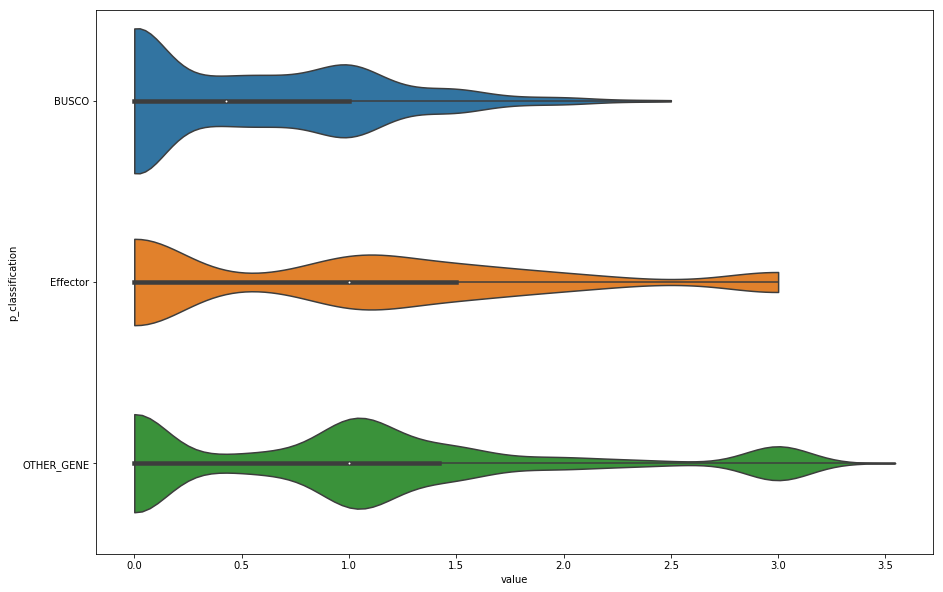

In [99]:
#not sure about this but it is interesting to look at and to consider so I left it here
df = allele_hit_df.loc[:,['protein/cds_levdist', "p_classification"]].fillna(0).copy()
qdf = quant_cut_df(df.pivot(values='protein/cds_levdist', columns= 'p_classification'))

f, ax = plt.subplots(figsize=(15, 10))
df = qdf.melt()
#ax.set_xscale("log")
sns.violinplot(x='value', y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

In [104]:
#these lines of code are used to look at the variation at the protein level
#these are part of table 2 of the ms
#could be done better
df = allele_hit_df.loc[:,['protein_levenshtein', "p_classification"]].copy()
df = df.pivot(values='protein_levenshtein', columns= 'p_classification')
t_be, p_be = stats.ranksums(df.BUSCO.dropna().values, df.Effector.dropna().values)
t_oe, p_oe = stats.ranksums(df.OTHER_GENE.dropna().values, df.Effector.dropna().values)
print(stats.ranksums(df.BUSCO.dropna().values, df.Effector.dropna().values))
print(stats.ranksums(df.OTHER_GENE.dropna().values, df.Effector.dropna().values))
print(statsmodels.sandbox.stats.multicomp.multipletests([p_be, p_oe],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))
print((df.BUSCO.dropna().values ==0).sum()\
      ,(df.Effector.dropna().values ==0).sum()\
      ,(df.OTHER_GENE.dropna().values ==0).sum())
print((df.BUSCO.dropna().values ==0).sum()/
      len(df.BUSCO.dropna().values),\
      (df.Effector.dropna().values ==0).sum()/\
      len(df.Effector.dropna().values),\
      (df.OTHER_GENE.dropna().values ==0).sum()/\
     len(df.OTHER_GENE.dropna().values))
print('Mean')
print(df.BUSCO.dropna().mean(),df.Effector.dropna().mean(),df.OTHER_GENE.dropna().mean() )
print('Median')
print(df.BUSCO.dropna().median(),df.Effector.dropna().median(),df.OTHER_GENE.dropna().median() )
df.describe()

RanksumsResult(statistic=-4.0685231148797234, pvalue=4.7312068214608662e-05)
RanksumsResult(statistic=4.4327371548756327, pvalue=9.3044269547450971e-06)
(array([ True,  True], dtype=bool), array([  9.46241364e-05,   1.86088539e-05]), 0.025320565519103666, 0.025)
422 484 2481
0.35225375626 0.398682042834 0.291573627923
Mean
0.026462810242390288 0.047404566502282496 0.06372272433230451
Median
0.0028169237605535453 0.006006493506493507 0.007575757575757577


p_classification,BUSCO,Effector,OTHER_GENE
count,1198.000000,1214.000000,8509.000000
mean,0.026463,0.047405,0.063723
std,0.072211,0.095963,0.126181
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.002817,0.006006,0.007576
75%,0.014429,0.039832,0.049505
max,0.613811,0.612782,0.806084


In [105]:
df = allele_hit_df.loc[:,['cds_levenshtein', "p_classification"]].copy()
df = df.pivot(values='cds_levenshtein', columns= 'p_classification')
t_be, p_be = stats.ranksums(df.BUSCO.dropna().values, df.Effector.dropna().values)
t_oe, p_oe = stats.ranksums(df.OTHER_GENE.dropna().values, df.Effector.dropna().values)
print(stats.ranksums(df.BUSCO.dropna().values, df.Effector.dropna().values))
print(stats.ranksums(df.OTHER_GENE.dropna().values, df.Effector.dropna().values))
print(statsmodels.sandbox.stats.multicomp.multipletests([p_be, p_oe],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))
print((df.BUSCO.dropna().values ==0).sum()\
      ,(df.Effector.dropna().values ==0).sum()\
      ,(df.OTHER_GENE.dropna().values ==0).sum())
print((df.BUSCO.dropna().values ==0).sum()/
      len(df.BUSCO.dropna().values),\
      (df.Effector.dropna().values ==0).sum()/\
      len(df.Effector.dropna().values),\
      (df.OTHER_GENE.dropna().values ==0).sum()/\
     len(df.OTHER_GENE.dropna().values))
print(df.BUSCO.dropna().mean(),df.Effector.dropna().mean(),df.OTHER_GENE.dropna().mean() )
print(df.BUSCO.dropna().median(),df.Effector.dropna().median(),df.OTHER_GENE.dropna().median() )
df.describe()

RanksumsResult(statistic=1.9831977958239608, pvalue=0.047345340018046141)
RanksumsResult(statistic=6.5425629767203723, pvalue=6.0473356049281376e-11)
(array([False,  True], dtype=bool), array([  9.46906800e-02,   1.20946712e-10]), 0.025320565519103666, 0.025)
228 413 1791
0.190317195326 0.340197693575 0.210483017981
0.028763144144375773 0.04068398168371404 0.057879375674427226
0.0066815144766147 0.004444444444444445 0.007407407407407408


p_classification,BUSCO,Effector,OTHER_GENE
count,1198.000000,1214.000000,8509.000000
mean,0.028763,0.040684,0.057879
std,0.070337,0.087243,0.115095
min,0.000000,0.000000,0.000000
25%,0.000642,0.000000,0.000734
50%,0.006682,0.004444,0.007407
75%,0.021833,0.031040,0.040936
max,0.609335,0.541353,0.733333


In [106]:
df = allele_hit_df.loc[:,['vn00_dN/dS', "p_classification"]].copy()
df = df.pivot(values='vn00_dN/dS', columns= 'p_classification')
t_be, p_be = stats.ranksums(df.BUSCO.dropna().values, df.Effector.dropna().values)
t_oe, p_oe = stats.ranksums(df.OTHER_GENE.dropna().values, df.Effector.dropna().values)
print(stats.ranksums(df.BUSCO.dropna().values, df.Effector.dropna().values))
print(stats.ranksums(df.OTHER_GENE.dropna().values, df.Effector.dropna().values))
print(statsmodels.sandbox.stats.multicomp.multipletests([p_be, p_oe],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))
print((df.BUSCO.dropna().values ==0).sum()\
      ,(df.Effector.dropna().values ==0).sum()\
      ,(df.OTHER_GENE.dropna().values ==0).sum())
print((df.BUSCO.dropna().values ==0).sum()/
      len(df.BUSCO.dropna().values),\
      (df.Effector.dropna().values ==0).sum()/\
      len(df.Effector.dropna().values),\
      (df.OTHER_GENE.dropna().values ==0).sum()/\
     len(df.OTHER_GENE.dropna().values))
print(df.BUSCO.dropna().mean(),df.Effector.dropna().mean(),df.OTHER_GENE.dropna().mean() )
print(df.BUSCO.dropna().median(),df.Effector.dropna().median(),df.OTHER_GENE.dropna().median() )
df.describe()

RanksumsResult(statistic=-15.567464699574142, pvalue=1.2111342712772745e-54)
RanksumsResult(statistic=-4.9010287985928693, pvalue=9.5336078322506395e-07)
(array([ True,  True], dtype=bool), array([  2.42226854e-54,   1.90672157e-06]), 0.025320565519103666, 0.025)
213 82 814
0.247962747381 0.132471728595 0.150657042384
0.20126111418949297 0.47973187214757995 0.4317729067872116
0.08021390374331551 0.39721254355400704 0.2839506172839506


p_classification,BUSCO,Effector,OTHER_GENE
count,859.000000,619.000000,5403.000000
mean,0.201261,0.479732,0.431773
std,0.358592,0.458077,0.534643
min,-0.000000,-0.000000,-0.000000
25%,0.007175,0.169731,0.084701
50%,0.080214,0.397213,0.283951
75%,0.244459,0.692591,0.606329
max,3.454545,3.798611,10.428571


In [107]:
df = allele_hit_df.loc[:,['LWL85m_dN/dS', "p_classification"]].copy()
df = df.pivot(values='LWL85m_dN/dS', columns= 'p_classification')
t_be, p_be = stats.ranksums(df.BUSCO.dropna().values, df.Effector.dropna().values)
t_oe, p_oe = stats.ranksums(df.OTHER_GENE.dropna().values, df.Effector.dropna().values)
print(stats.ranksums(df.BUSCO.dropna().values, df.Effector.dropna().values))
print(stats.ranksums(df.OTHER_GENE.dropna().values, df.Effector.dropna().values))
print(statsmodels.sandbox.stats.multicomp.multipletests([p_be, p_oe],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))
print((df.BUSCO.dropna().values ==0).sum()\
      ,(df.Effector.dropna().values ==0).sum()\
      ,(df.OTHER_GENE.dropna().values ==0).sum())
print((df.BUSCO.dropna().values ==0).sum()/
      len(df.BUSCO.dropna().values),\
      (df.Effector.dropna().values ==0).sum()/\
      len(df.Effector.dropna().values),\
      (df.OTHER_GENE.dropna().values ==0).sum()/\
     len(df.OTHER_GENE.dropna().values))
print(df.BUSCO.dropna().mean(),df.Effector.dropna().mean(),df.OTHER_GENE.dropna().mean() )
print(df.BUSCO.dropna().median(),df.Effector.dropna().median(),df.OTHER_GENE.dropna().median() )
df.describe()

RanksumsResult(statistic=-14.766427624137291, pvalue=2.4116107498224865e-49)
RanksumsResult(statistic=-3.9129416568717192, pvalue=9.1178569708247822e-05)
(array([ True,  True], dtype=bool), array([  4.82322150e-49,   1.82357139e-04]), 0.025320565519103666, 0.025)
150 52 579
0.192307692308 0.0950639853748 0.118453355155
0.20383107027228764 0.4727579619340935 0.440833817422581
0.10383021102497847 0.37759336099585067 0.2837663534180947


p_classification,BUSCO,Effector,OTHER_GENE
count,780.000000,547.000000,4888.000000
mean,0.203831,0.472758,0.440834
std,0.297731,0.466847,0.517568
min,0.000000,0.000000,0.000000
25%,0.030479,0.174308,0.101662
50%,0.103830,0.377593,0.283766
75%,0.237302,0.655396,0.600175
max,2.666667,4.500000,8.247312


[]

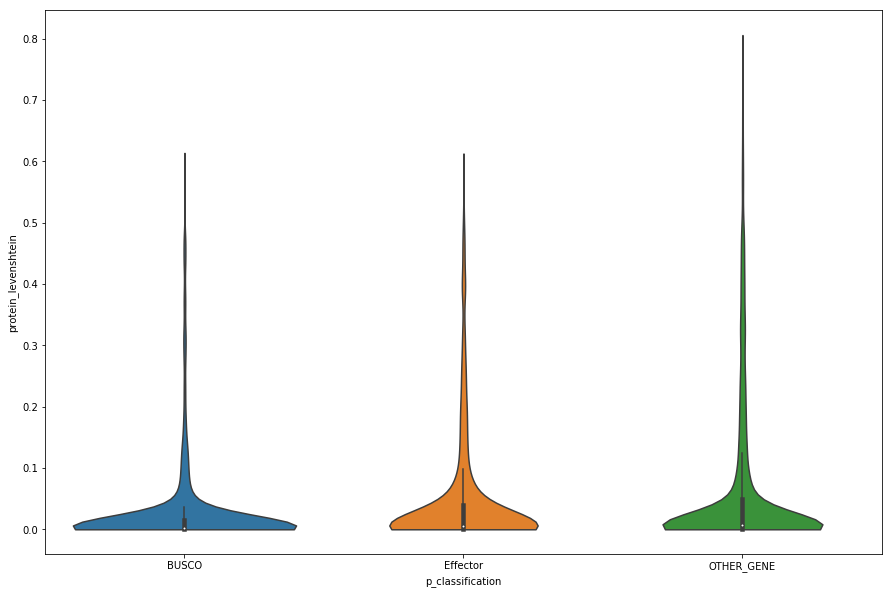

In [109]:
#some quick plots do visualize the data
f, ax = plt.subplots(figsize=(15, 10))
df = allele_hit_df.loc[:,['protein_levenshtein', "p_classification"]].fillna(0).copy()
#ax.set_xscale("log")
sns.violinplot(y='protein_levenshtein', x="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

[]

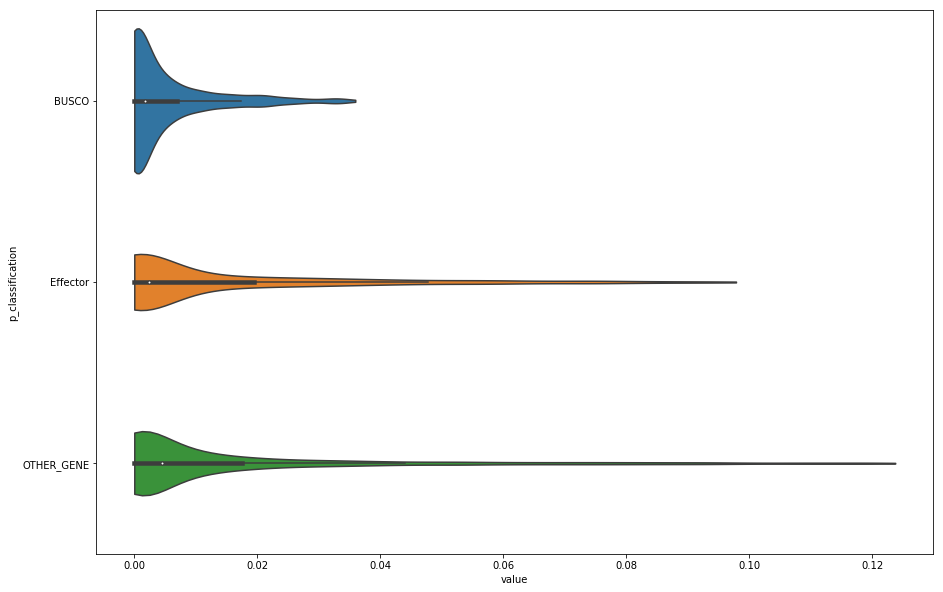

In [110]:
df = allele_hit_df.loc[:,['protein_levenshtein', "p_classification"]].copy()
qdf = quant_cut_df(df.pivot(values='protein_levenshtein', columns= 'p_classification'))

f, ax = plt.subplots(figsize=(15, 10))
df = qdf.melt()
#ax.set_xscale("log")
sns.violinplot(x='value', y="p_classification", data=df, cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='value', y="p_classification", data=df,size=2, color=".3", linewidth=0)

[]

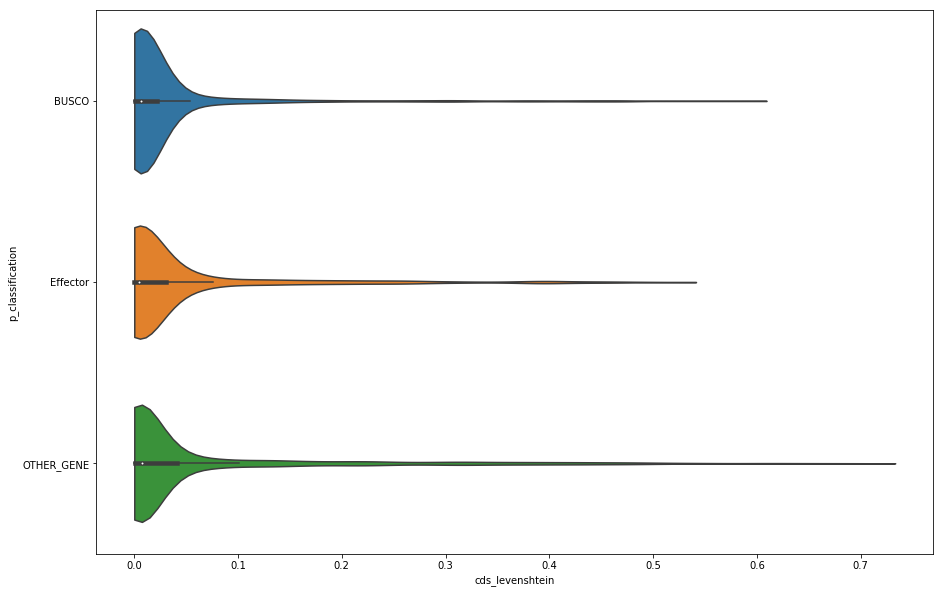

In [111]:
f, ax = plt.subplots(figsize=(15, 10))
df = allele_hit_df.loc[:,['cds_levenshtein', "p_classification"]].fillna(0).copy()
#ax.set_xscale("log")
sns.violinplot(x='cds_levenshtein', y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

[]

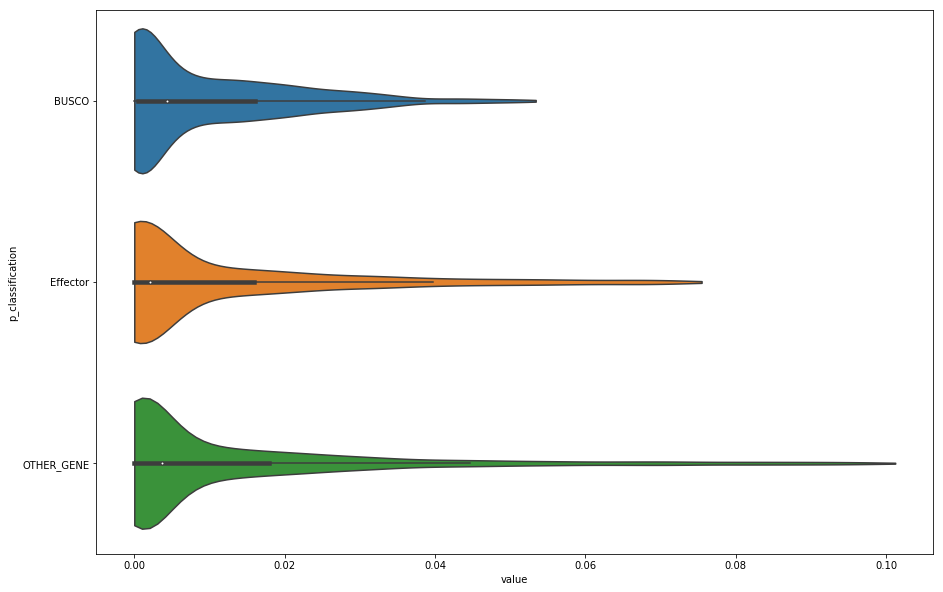

In [112]:
df = allele_hit_df.loc[:,['cds_levenshtein', "p_classification"]].copy()
qdf = quant_cut_df(df.pivot(values='cds_levenshtein', columns= 'p_classification'))

f, ax = plt.subplots(figsize=(15, 10))
df = qdf.melt()
#ax.set_xscale("log")
sns.violinplot(x='value', y="p_classification", data=df.sort_values("p_classification"), cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x='protein/cds_levdist', y="p_classification", data=df,
              #size=2, color=".3", linewidth=0)

The next section is about overlaying/attaching the allelic variation level with physical distances

In [115]:
e_to_b_closest_df = feature_bed_dict['effector'].closest(feature_bed_dict['busco']\
                                    ,d=True,t='last', io=True).to_dataframe().iloc[:,[3,9,12]]
new_header = ['Effector', 'Busco', 'distance']
e_to_b_closest_df.rename(columns=dict(zip(e_to_b_closest_df.columns, new_header)), inplace=True)

e_to_b_closest_df = e_to_b_closest_df[e_to_b_closest_df.Busco != '.']

#now add the classification for each effector
e_to_b_closest_df['Classification'] = "Allele"
singleton_array = e_to_b_closest_df.Effector.str.replace('TU','model').isin(singeltons)
e_to_b_closest_df.loc[e_to_b_closest_df[singleton_array].index,'Classification' ] = "Singleton"
no_allele_ortho_array = e_to_b_closest_df.Effector.str\
    .replace('TU','model').isin(no_allele_orthologs)
e_to_b_closest_df.loc[e_to_b_closest_df[no_allele_ortho_array].index,'Classification' ] \
= "Non-allelic protein 'orthologs'"
allele_array = e_to_b_closest_df.Effector.str\
    .replace('TU','model').isin(allele_hit_df.Query.unique())
e_to_b_closest_df.loc[e_to_b_closest_df[allele_array].index,'Classification' ] = "Allele"

/home/benjamin/anaconda3/lib/python3.5/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [116]:
e_to_b_closest_df.sort_values(by='Classification', inplace= True)

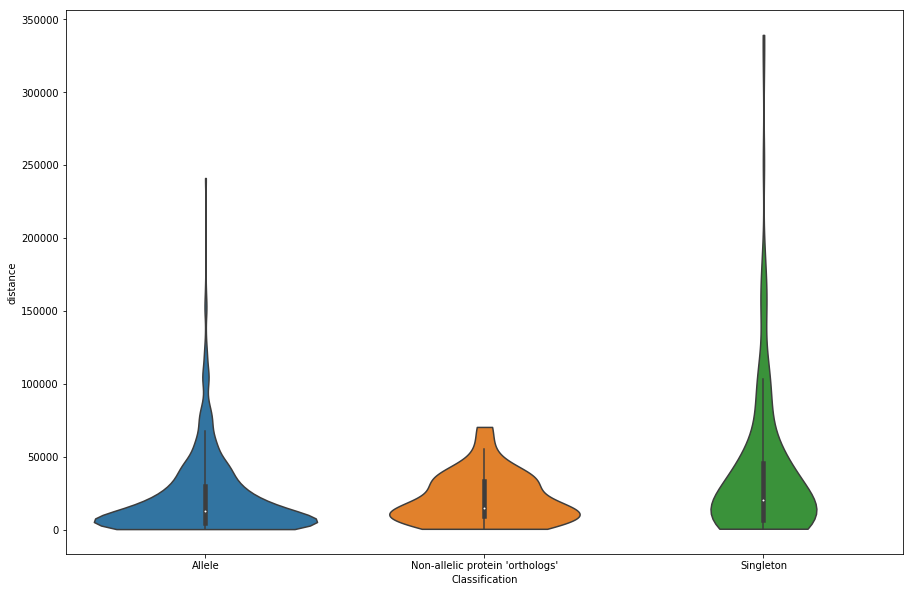

In [117]:
#quick plot ot look at distance of effectors to buscos according to their classification
f, ax = plt.subplots(figsize=(15, 10))
sns.violinplot(x='Classification', y='distance', data =e_to_b_closest_df, cut=0)

In [118]:
#do some stats on these distances
s_test = e_to_b_closest_df[e_to_b_closest_df.Classification == 'Singleton']['distance'].values
a_test = e_to_b_closest_df[e_to_b_closest_df.Classification == "Allele"]['distance'].values
n_test = e_to_b_closest_df[e_to_b_closest_df.Classification == \
                           "Non-allelic protein 'orthologs'"]['distance'].values
_, p_sa = stats.stats.ranksums(s_test, a_test)
_, p_sn = stats.stats.ranksums(s_test, n_test)
_, p_an = stats.stats.ranksums(a_test, n_test)  
print(p_sa, p_sn, p_an)
print(stats.stats.kruskal(s_test, n_test, a_test))
print(statsmodels.sandbox.stats.multicomp.multipletests([p_sa, p_sn, p_an],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))
_, [cp_sa,cp_sn, cp_an] , _, _ = statsmodels.sandbox.stats.multicomp.multipletests([p_sa, p_sn, p_an],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

4.33573451861e-07 0.277059927158 0.391575096337
KruskalResult(statistic=25.909444798257574, pvalue=2.3650239738701233e-06)
(array([ True, False, False], dtype=bool), array([  1.30072036e-06,   8.31179781e-01,   1.00000000e+00]), 0.016952427508441503, 0.016666666666666666)


4.33573451861e-07 0.277059927158 0.391575096337


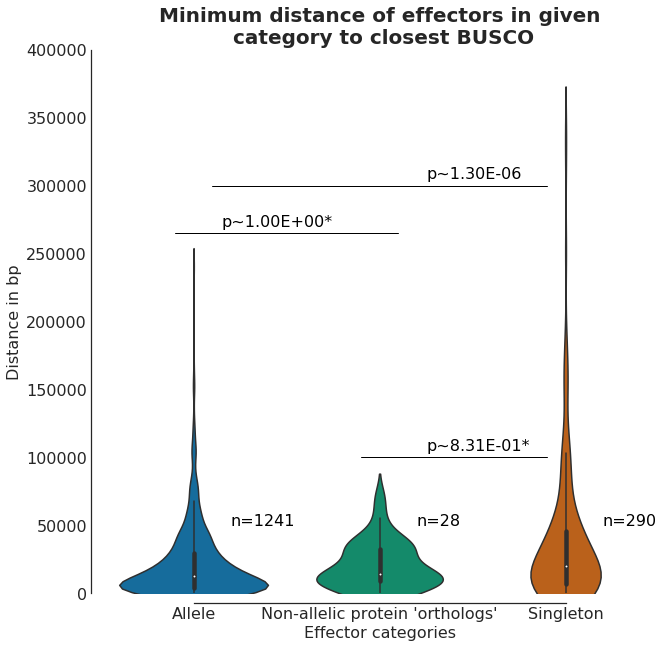

In [120]:
from matplotlib.font_manager import FontProperties
df = e_to_b_closest_df
sns.set_style("white")
#do a boxplot and swarmplot on the same data
fig, ax = plt.subplots(figsize=(10, 10))
#ax.set_xscale("log")
sns.violinplot(x='Classification', y='distance', data =e_to_b_closest_df, 
          whis=np.inf, palette=sns.color_palette('colorblind'))
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(y="value", x="variable", data=df,
 #           size=2, color=".3", linewidth=0)
#set the labels
plt.ylim(0, 400000)

#add the title
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)

title = 'Minimum distance of effectors in given category to closest BUSCO'
plt.title(title.replace('given', 'given\n'), fontproperties=font)

#add the title
font0 = FontProperties()
font_axis = font0.copy()
font_axis.set_size(16)

plt.xlabel("Effector categories", fontproperties=font_axis)
plt.ylabel('Distance in bp',fontproperties=font_axis)


#set font size for labels and such
fs = 16
print(p_sa, p_sn, p_an)
#plot the ns number is the plot as well
ax.text(0.2, 50000, 'n=%i'% len(a_test), color='k', fontsize=fs)
ax.text(1.2, 50000, 'n=%i'% len(n_test), color='k', fontsize=fs)
ax.text(2.2, 50000, 'n=%i'% len(s_test), color='k', fontsize=fs)
#add the stats to it as well with numbers and lines
ax.text(0.15, 270000, 'p~%.2E*'% cp_an, color='k', fontsize=fs)
ax.plot([-0.1, 1.1], [265000, 265000],color ='k' ,lw=1)
ax.text(1.25, 305000, 'p~%.2E'% cp_sa, color='k', fontsize=fs)
ax.plot([0.1, 1.9], [300000, 300000],color ='k' ,lw=1)
ax.text(1.25, 105000, 'p~%.2E*'% cp_sn, color='k', fontsize=fs)
ax.plot([0.9, 1.9], [100000, 100000],color ='k' ,lw=1)
sns.despine(offset=10, trim=True)

#fontsize of ticks
ax.tick_params(labelsize=fs)

#save the file as well
out_file_name = "_".join(title.split(' '))
#fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'.png'), dpi=600)

In [124]:
#quick summary of the data
e_to_b_closest_df.groupby('Classification')['distance'].describe().T

Classification,Allele,Non-allelic protein 'orthologs',Singleton
count,1241.000000,28.000000,290.000000
mean,22014.203868,20863.607143,38713.293103
std,26881.099463,17239.819754,52500.369794
min,281.000000,468.000000,525.000000
25%,4122.000000,9199.250000,6618.750000
50%,12689.000000,14560.500000,20255.500000
75%,29960.000000,32927.250000,45924.500000
max,241042.000000,70337.000000,339166.000000


In [126]:
e_allele_to_b_closest_df = e_to_b_closest_df[e_to_b_closest_df.Classification == 'Allele'].copy()

In [127]:
#now fuse all the other variables previously calucated to the distance dataframe
e_allele_to_b_closest_df['Query'] = e_allele_to_b_closest_df.Effector.apply(lambda x:
                                                                           x.replace('TU','model'))

e_allele_to_b_closest_df = pd.merge(e_allele_to_b_closest_df,allele_hit_df.loc[:,\
            ['Query', 'codmel_dN/dS', 'protein_hamming',
       'cds_hamming', 'protein_levenshtein', 'cds_levenshtein', 'vn00_dN/dS',
       'LWL85_dN/dS', 'LWL85m_dN/dS', 'LPB93_dN/dS', 'protein/cds_levdist']], on='Query')

SpearmanrResult(correlation=-0.0073986402945872744, pvalue=0.79693757666057463)


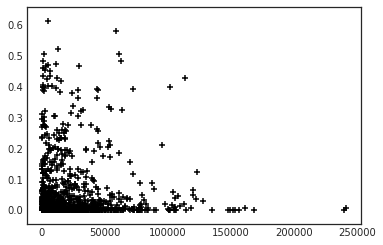

In [131]:
#this is the quick calculation if there is a correlation between distance to busco and 
#levensthein distance on the protein level
df = e_allele_to_b_closest_df[e_allele_to_b_closest_df['protein_levenshtein'] > -0.1]
x_now = df.distance
y_now=df['protein_levenshtein']
plt.scatter(x=x_now,y=y_now, marker ='+', color='k')
print(stats.spearmanr(x_now, y_now,nan_policy='omit'))

SpearmanrResult(correlation=0.051510462188612736, pvalue=0.2013386144439768)


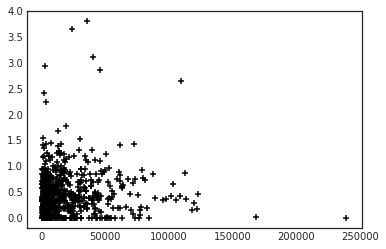

In [133]:
#this is the quick calculation if there is a correlation between distance to busco and 
#levensthein distance on the protein level
df = e_allele_to_b_closest_df[e_allele_to_b_closest_df['vn00_dN/dS'] > -0.1]
x_now = df.distance
y_now=df['vn00_dN/dS']
plt.scatter(x=x_now,y=y_now, marker ='+', color='k')
print(stats.spearmanr(x_now, y_now,nan_policy='omit'))

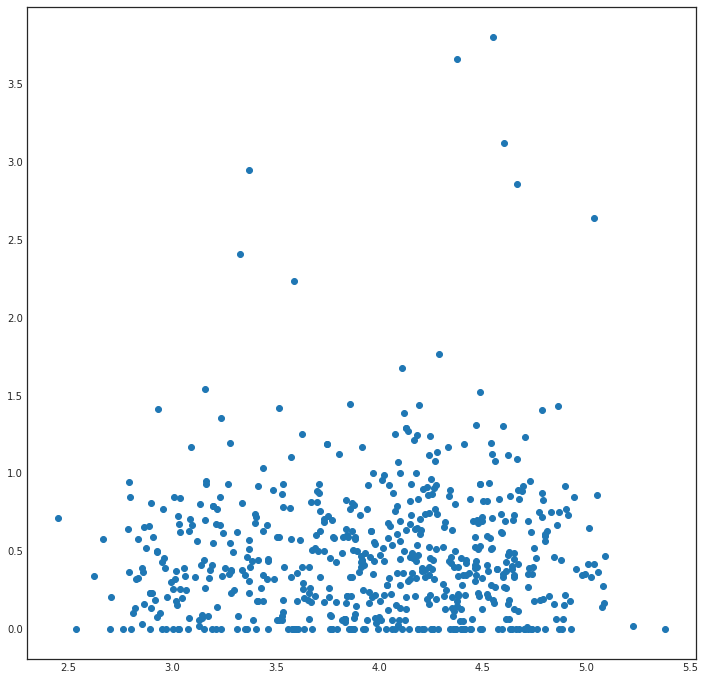

In [132]:
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=np.log10(e_allele_to_b_closest_df.distance), y=e_allele_to_b_closest_df['vn00_dN/dS'] )

In [134]:
#make a closest_df with Classificaiton and allelic variation
e_to_g_closest_df = feature_bed_dict['effector'].closest(feature_bed_dict['genes']\
                                    ,d=True,t='last', io=True).to_dataframe().iloc[:,[3,9,12]]
new_header = ['Effector', 'gene', 'distance']
e_to_g_closest_df.rename(columns=dict(zip(e_to_g_closest_df.columns, new_header)), inplace=True)

e_to_g_closest_df = e_to_g_closest_df[e_to_g_closest_df.gene != '.']

#now add the Classification for each effector
e_to_g_closest_df['Classification'] = "Allele"
singleton_array = e_to_g_closest_df.Effector.str.replace('TU','model').isin(singeltons)
e_to_g_closest_df.loc[e_to_g_closest_df[singleton_array].index,'Classification' ] = "Singleton"
no_allele_ortho_array = e_to_g_closest_df.Effector.str\
    .replace('TU','model').isin(no_allele_orthologs)
e_to_g_closest_df.loc[e_to_g_closest_df[no_allele_ortho_array].index,'Classification' ] = \
"Non-allelic protein 'orthologs'"
allele_array = e_to_g_closest_df.Effector.str\
    .replace('TU','model').isin(allele_hit_df.Query.unique())
e_to_g_closest_df.loc[e_to_g_closest_df[allele_array].index,'Classification' ] = "Allele"

#now for alleles
e_allele_to_g_closest_df = e_to_g_closest_df[e_to_g_closest_df.Classification == 'Allele'].copy()
e_allele_to_g_closest_df['Query'] = e_allele_to_g_closest_df.Effector.apply(lambda x:
                                                                           x.replace('TU','model'))

e_allele_to_g_closest_df = pd.merge(e_allele_to_g_closest_df,allele_hit_df.loc[:,\
            ['Query', 'codmel_dN/dS', 'protein_hamming',
       'cds_hamming', 'protein_levenshtein', 'cds_levenshtein', 'vn00_dN/dS',
       'LWL85_dN/dS', 'LWL85m_dN/dS', 'LPB93_dN/dS', 'protein/cds_levdist']], on='Query')

/home/benjamin/anaconda3/lib/python3.5/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [136]:
e_to_g_closest_df.sort_values(by='Classification', inplace=True)

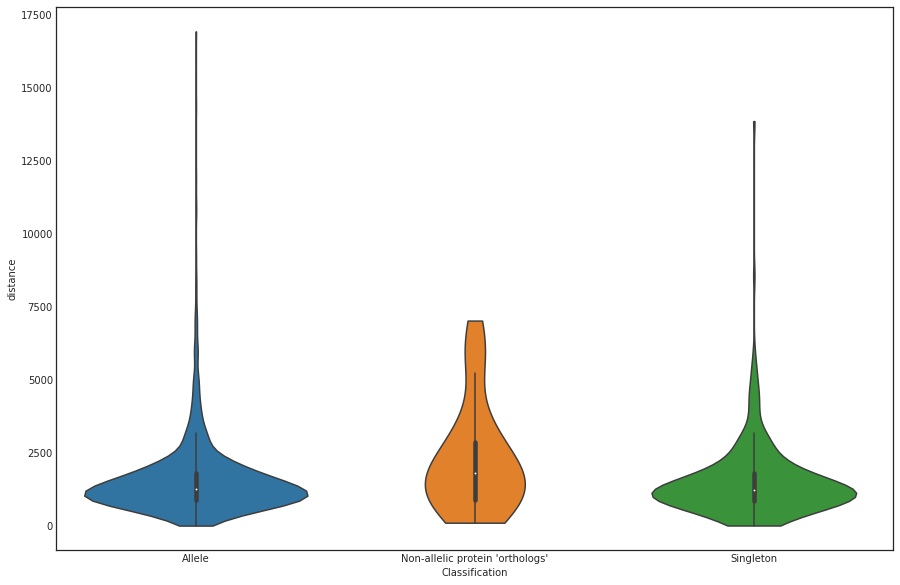

In [137]:
#quick plot
f, ax = plt.subplots(figsize=(15, 10))
sns.violinplot(x='Classification', y='distance', data =e_to_g_closest_df, cut=0)

In [138]:
s_test = e_to_g_closest_df[e_to_g_closest_df.Classification == 'Singleton']['distance'].values
a_test = e_to_g_closest_df[e_to_g_closest_df.Classification == "Allele"]['distance'].values
n_test = e_to_g_closest_df[e_to_g_closest_df.Classification == \
                           "Non-allelic protein 'orthologs'"]['distance'].values
_, p_sa = stats.stats.ranksums(s_test, a_test)
_, p_sn = stats.stats.ranksums(s_test, n_test)
_, p_an = stats.stats.ranksums(a_test, n_test)  
print(p_sa, p_sn, p_an)
print(stats.stats.kruskal(s_test, n_test, a_test))
print(statsmodels.sandbox.stats.multicomp.multipletests([p_sa, p_sn, p_an],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))
_, [cp_sa,cp_sn, cp_an] , _, _ = statsmodels.sandbox.stats.multicomp.multipletests([p_sa, p_sn, p_an],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

0.323194573051 0.0366144806652 0.0493388181324
KruskalResult(statistic=4.9963466230767004, pvalue=0.082235079377417655)
(array([False, False, False], dtype=bool), array([ 0.96958372,  0.10984344,  0.14801645]), 0.016952427508441503, 0.016666666666666666)


0.323194573051 0.0366144806652 0.0493388181324


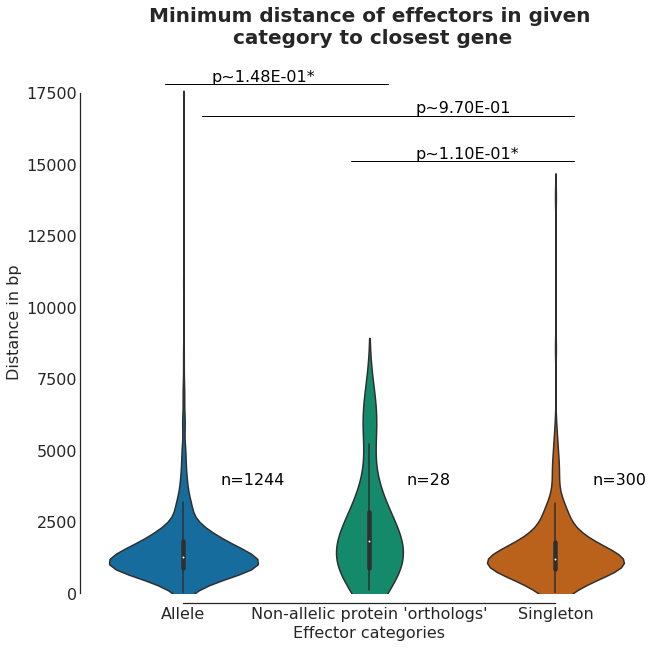

In [139]:
from matplotlib.font_manager import FontProperties
df = e_to_b_closest_df
sns.set_style("white")
#do a boxplot and swarmplot on the same data
fig, ax = plt.subplots(figsize=(10, 10))
#ax.set_xscale("log")
sns.violinplot(x='Classification', y='distance', data =e_to_g_closest_df, 
          whis=np.inf, palette=sns.color_palette('colorblind'))
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(y="value", x="variable", data=df,
 #           size=2, color=".3", linewidth=0)
#set the labels
plt.ylim(0, 19000)

#add the title
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)

title = 'Minimum distance of effectors in given category to closest gene'
plt.title(title.replace('given', 'given\n'), fontproperties=font)

#add the title
font0 = FontProperties()
font_axis = font0.copy()
font_axis.set_size(16)

plt.xlabel("Effector categories", fontproperties=font_axis)
plt.ylabel('Distance in bp',fontproperties=font_axis)

#set font size for labels and such
fs = 16
print(p_sa, p_sn, p_an)

#plot the ns number is the plot as well
ax.text(0.2, 3800, 'n=%i'% len(a_test), color='k', fontsize=fs)
ax.text(1.2, 3800, 'n=%i'% len(n_test), color='k', fontsize=fs)
ax.text(2.2, 3800, 'n=%i'% len(s_test), color='k', fontsize=fs)
#add the stats to it as well with numbers and lines
ax.text(0.15, 17900, 'p~%.2E*'% cp_an, color='k', fontsize=fs)
ax.plot([-0.1, 1.1], [17800, 17800],color ='k' ,lw=1)
ax.text(1.25, 16800, 'p~%.2E'% cp_sa, color='k', fontsize=fs)
ax.plot([0.1, 2.1], [16700, 16700],color ='k' ,lw=1)
ax.text(1.25, 15200, 'p~%.2E*'% cp_sn, color='k', fontsize=fs)
ax.plot([0.9, 2.1], [15100, 15100],color ='k' ,lw=1)
sns.despine(offset=10, trim=True)

#fontsize of ticks
ax.tick_params(labelsize=fs)

#save the file as well
out_file_name = "_".join(title.split(' '))
#fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'.png'), dpi=600)